In [17]:
using PyPlot
using JuMP, Ipopt

In [18]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

## Model setup

#### Physical parameters

In [19]:
# Model domain
dt = 1.
t = Array(2020:dt:2200);

# "Best-guess equilibrium climate sensitivity"
ECS = 3.0;

#### Economic parameters

Assume damages of 2% of global world product (GWP) for 3$^{\circ}$C of warming (similar to DICE damage function).

In [20]:
GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

In [21]:
baseline_emissions_scenario = baseline_emissions(t, 5., 2060., 40.)

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0., # Assumed initial condition of no deployments in 2020
    baseline_emissions_scenario
);

### Initialize model

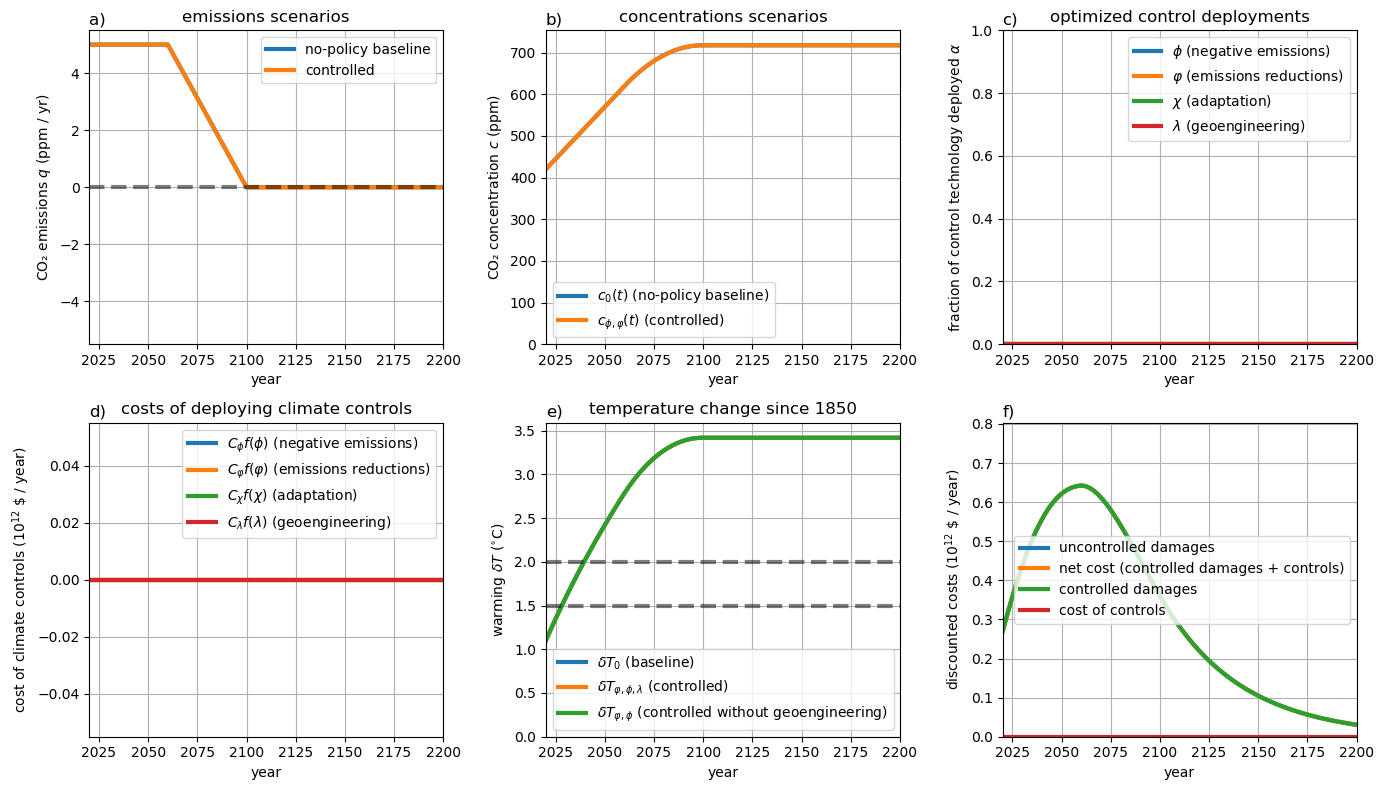

Social cost of carbon: $24.99.

In [22]:
ensemble = Dict{String, ClimateModel}();

name = "Example configuration";
present_year = 2020.

# Arbitrary initial guess of climate control policies,
# to be optimized later!
controls = init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
model = ClimateModel(name, ECS, t, dt, controls, economics, present_year);

# Plot initial state (baseline scenario; zero controls)
plot_state(model)

print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

# Model optimization

## Constraint on total discounted control budget

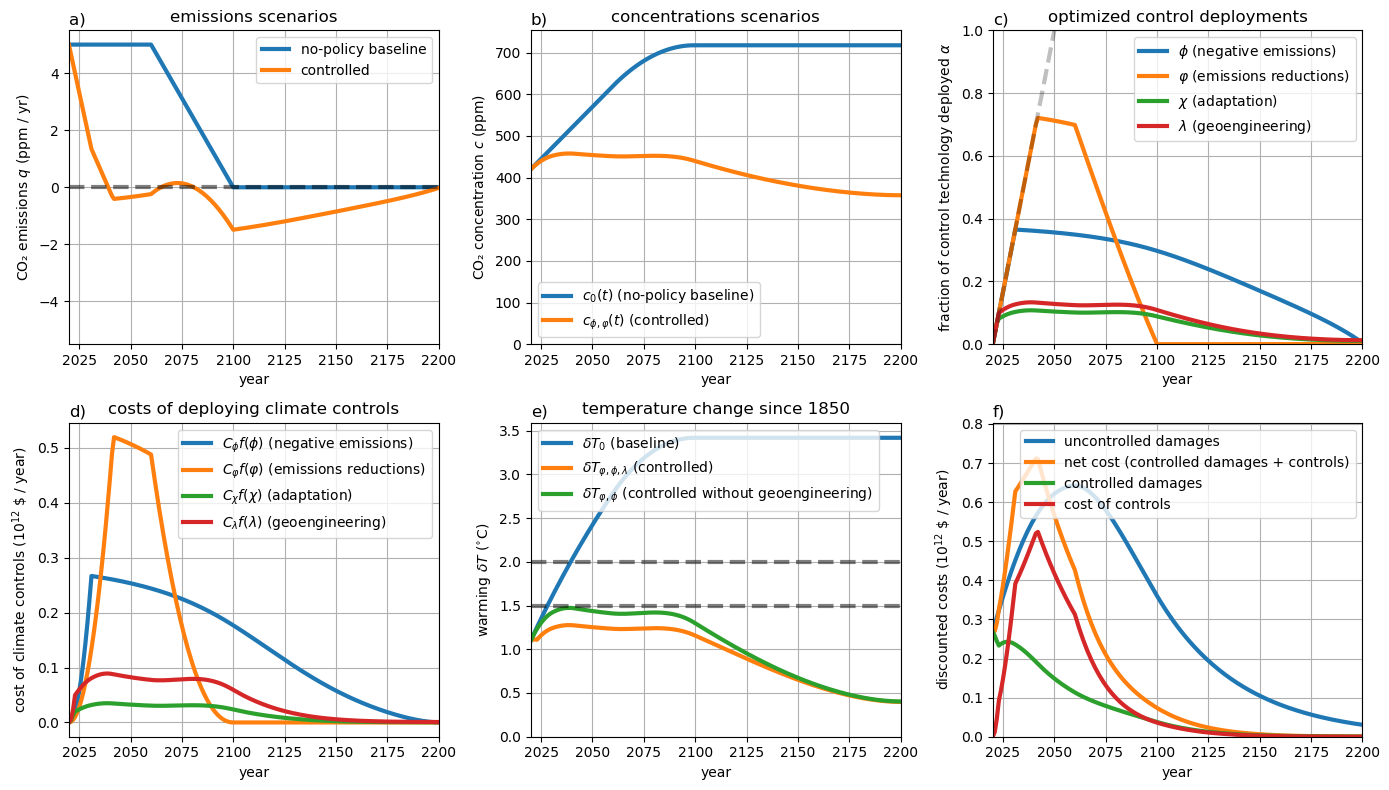

Found optimal solution for model name: Example configuration

In [23]:
maxslope = 1. /30.
optimize_controls!(model, obj_option = "budget", budget=20.);
plot_state(model)
subplot(2,3,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25)
savefig("../figures/model_state_example_fixed-budget.png", bbox_inches="tight", dpi=100)

## Annual expenditures constraint

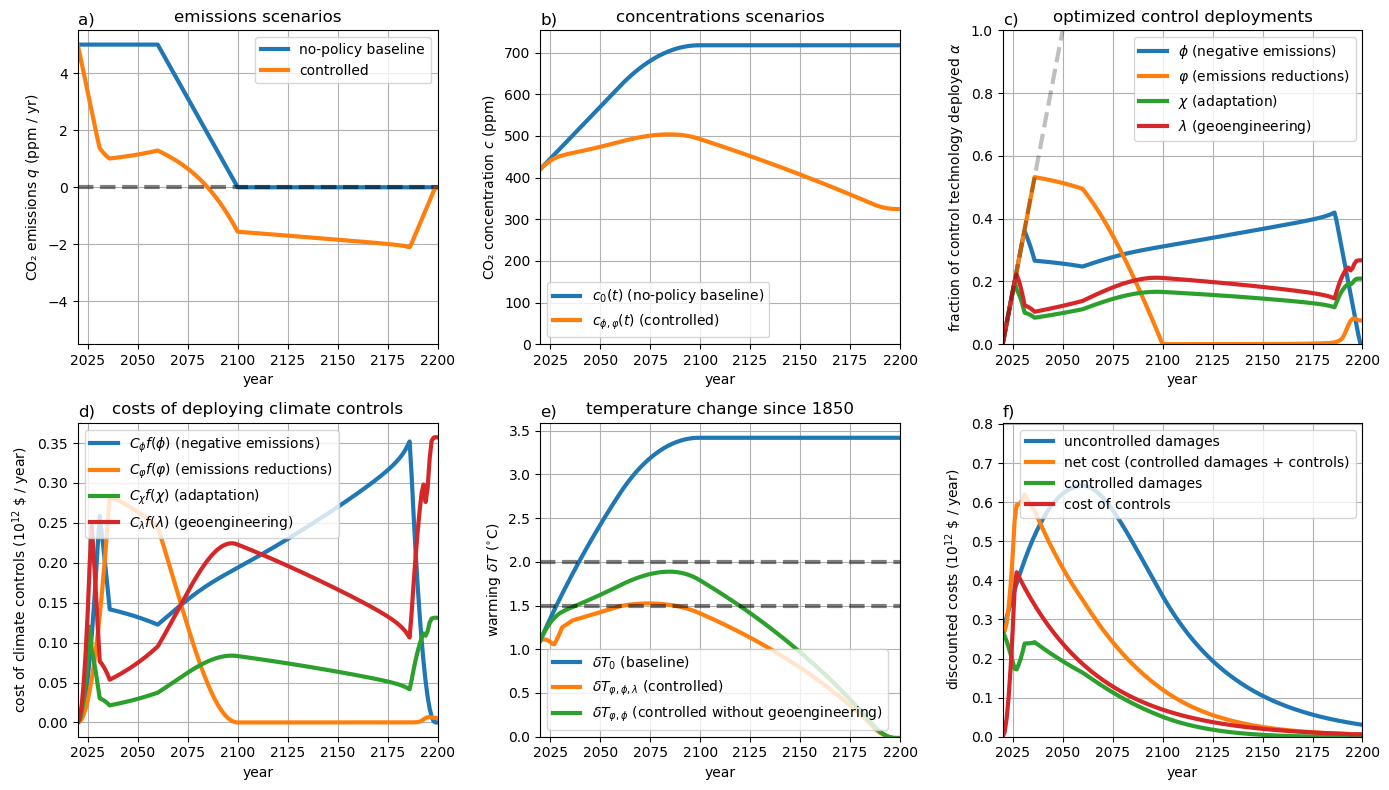

Found optimal solution for model name: Example configuration

In [24]:
optimize_controls!(model, obj_option = "expenditure", expenditure=0.5);
plot_state(model)
subplot(2,3,3)
plot([2020., 2020. + 1. /maxslope], [0.,1.], "k--", alpha=0.25)
savefig("../figures/model_state_example_fixed-annual-expenditure.png", bbox_inches="tight", dpi=100)